https://www.kaggle.com/datasets/bittlingmayer/amazonreviews

### EDA Goals:
1. Get to know the data
2. Experiment with NLP techniques
3. Understand how hard the k-anonimyty task is going to be:)


### EDA questions:
1. How many different words in the dataset?
2. What are the most similar documents?
3. Experiment with seq2seq
4. Experiment with sentiment analysis
5. Experiment with BOW 
6. Experiment with Key-phrases extraction
7. check if we have any k repetittions of key-phrases. - TBD
8. Check if all documents are in English?


#-------------------------------------------------------------------------------#

Uploading the data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # For visualizations
import re # For regular expressions
import string # For handling string
import math # For performing mathematical operations

In [3]:
COLAB = True
first_run = True

In [4]:
if COLAB:
    from google.colab import drive
    from os.path import exists

    amazon_train_file = 'train.ft.txt.bz2'

    if exists(amazon_train_file):
        train_file = amazon_train_file
    else:
        drive.mount('/content/drive/')

        # For Hadas' drive
        #my_dir = 'drive/MyDrive/Y-data/Intuit-K-anonimity/'

        # For Lior's drive
        my_dir = 'drive/MyDrive/Y-data/Y-DATA_PROJECT/'

        train_file = my_dir + '/train.ft.txt.bz2'
else:
    train_file = '../data/' + 'train.ft.txt.bz2'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Definig the labels and the sentences

In [5]:
# Credit https://www.kaggle.com/code/anshulrai/cudnnlstm-implementation-93-7-accuracy

import bz2

# Readling the file to list of comments
train_file = bz2.BZ2File(train_file)
train_file_lines = train_file.readlines()

# Converting from raw binary strings to strings that can be parsed
train_file_lines = [x.decode('utf-8') for x in train_file_lines]

# Extracting the labels and sentences
train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in train_file_lines]
train_sentences = [x.split(' ', 1)[1][:-1].lower() for x in train_file_lines] # And converting to lower case


Defining the dataframe

In [6]:
df = pd.DataFrame(list(zip(train_sentences, train_labels)), columns =['txt', 'sentiment'])
# saving the original df:
# df_original = df.copy() # not enough RAM

Initial Data Exploration

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3599663 entries, 0 to 3599999
Data columns (total 3 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   txt           object
 1   sentiment     int64 
 2   num_of_words  int64 
dtypes: int64(2), object(1)
memory usage: 109.9+ MB


In [12]:
df.head()

,txt,sentiment,num_of_words
0,stuning even for the non-gamer: this sound tra...,1,80
1,the best soundtrack ever to anything.: i'm rea...,1,97
2,amazing!: this soundtrack is my favorite music...,1,129
3,excellent soundtrack: i truly like this soundt...,1,118
4,"remember, pull your jaw off the floor after he...",1,87


In [25]:
df.describe(include='all')

,txt,sentiment
count,3600000,3600000.0
unique,3599662,NaN
top,fram is trash: fram is trash. i have removed s...,NaN
freq,4,NaN
mean,NaN,0.5
std,NaN,0.5
min,NaN,0.0
25%,NaN,0.0
50%,NaN,0.5
75%,NaN,1.0


We can see wee have 3.6 milion documents. the labels are balanced. 
The unique is something we would like to check, are there duplicates?

In [7]:
# Print the duplicate rows
print(df.loc[df.duplicated(keep=False), :])

                                                       txt  sentiment
15115    no audio output from blu-ray version: warning ...          0
15725    poor quality & service: my panasonic over-the-...          0
30483    french garbage: this review may sound pretenti...          0
33086    very small and only 8 pictures: this coloring ...          0
38511    collectors beware: ok so the world is a big pl...          0
...                                                    ...        ...
3578163  very large: i had expected these to be small s...          0
3578781  awesome phone, but sprint is intolerable: treo...          0
3581605  non existent after sales service...: i bought ...          0
3581764  customer service is an oxymoron: bought the 3p...          0
3583185  customer service is an oxymoron: bought the 3p...          0

[669 rows x 2 columns]


In [27]:
# printing two duplicates - how should we handle duplicates in the dataset?
print(df.loc[3581764, 'txt'])
print(df.loc[3583185, 'txt'])

customer service is an oxymoron: bought the 3pack for home use. installed it on two pc's and then had defective a defective new pc that it was installed on and removed. now, it won't let me activate on the new computer - their system is flawed!!!! they want me to mail in original invoice, unlock code and disk and then they'll see what they want to do. this will all take at least 2 to 3 weeks, in the meantime there is no protection on this computer. haaaaa!they really need to have a specific code for each activation so that it updates to the active computer it is being used on - they really could figure this out. they're taking the easy way out and getting more $$$ in the process.this combined with all other slow down issues, i'm switching to zone suite, as i've used zone alarm for years and it is great.best of luck.
customer service is an oxymoron: bought the 3pack for home use. installed it on two pc's and then had defective a defective new pc that it was installed on and removed. now

Remove duplicates, check if the data is still balanced

In [7]:
# Remove duplicates
df = df.drop_duplicates()

In [13]:
df.sentiment.value_counts() # pretty balanced but more negative sentiments had duplicates

1    1799940
0    1799723
Name: sentiment, dtype: int64

In [30]:
df.describe()

,sentiment
count,3.599663e+06
mean,5.000301e-01
std,5.000001e-01
min,0.000000e+00
25%,0.000000e+00
50%,1.000000e+00
75%,1.000000e+00
max,1.000000e+00


In [28]:
df.isnull().sum() # check if any null's in the dataset

txt          0
sentiment    0
dtype: int64

In [13]:
#from pandas_profiling import ProfileReport
#profile = ProfileReport(df)
#profile

Number of words - distribution

In [8]:
# add a colum of number of words per document (prior to any pre-processing of text)
df['num_of_words'] = df['txt'].apply(lambda x : len(x.split(' ')))
df.sample(5)

,txt,sentiment,num_of_words
812453,pinball awesomeness.: do you want a pinball ga...,1,64
1986436,some good extra material but...: if i had not ...,0,109
3535182,great book for me ..: i have read this book fo...,1,51
998529,enjoyable read: the first maeve binvy book i r...,1,166
2415564,poor quality: legs are crooked and 3 of the go...,0,23


In [32]:
# print the max min
print(f'Minimum num of words per document {int(np.round(df["num_of_words"].min()))} words')
print(f'Minimum num of words per document {int(np.round(df["num_of_words"].max()))} words')
print(f'In average, each document contains {int(np.round(df["num_of_words"].mean()))} words')

Minimum num of words per document 2 words
Minimum num of words per document 257 words
In average, each document contains 78 words


In [33]:
df.describe()

,sentiment,num_of_words
count,3.599663e+06,3.599663e+06
mean,5.000301e-01,7.848158e+01
std,5.000001e-01,4.283219e+01
min,0.000000e+00,2.000000e+00
25%,0.000000e+00,4.200000e+01
50%,1.000000e+00,7.000000e+01
75%,1.000000e+00,1.080000e+02
max,1.000000e+00,2.570000e+02


Print the longest and the shortest documents

In [37]:
df.sort_values(by=['num_of_words']).head(2)

,txt,sentiment,num_of_words
567147,great: teterriffic!terriffic!terriffic!terriff...,1,2
1373977,booo: booooooooooooooooooooooooooooooooooooooo...,0,2


In [38]:
df.sort_values(by=['num_of_words']).head(2).txt.tolist()

['great: teterriffic!terriffic!terriffic!terriffic!terriffic!terriffic!terriffic!terriffic!terriffic!terriffic!terriffic!terriffic!',
 'booo: booooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo']

In [39]:
len(str(df.sort_values(by=['num_of_words']).head(1).txt)) # count "letters" 

84

In [40]:
df.sort_values(by=['num_of_words']).tail(1) # longest document

,txt,sentiment,num_of_words
3071621,ilok is rubbish!!: i have never been able to g...,0,257


Document size distribution

Text(0, 0.5, 'Documents')

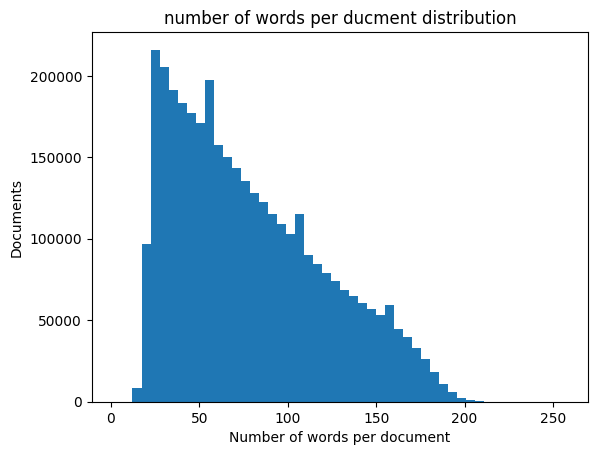

In [10]:
plt.hist(df['num_of_words'], bins=50)
plt.title('number of words per ducment distribution')
plt.xlabel('Number of words per document')
plt.ylabel('Documents')

## 1. How many different words in the dataset?


In [9]:
# Split the text into words and get the unique words
#unique_words = pd.Series(' '.join(df['txt']).split()).unique()
word_counts = pd.Series(' '.join(df['Text']).split()).value_counts()
# Count the number of unique words
print('Number of unique words:', len(word_counts))


KeyError: ignored

## 2. What are the most similar documents?

So, after removing the duplicates, we will use sentence embedding to find the most similar sentences


In [ ]:
## TBD

In [23]:
!pip install sentence_transformers -q  # https://www.sbert.net/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 67.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 84.5 MB/s eta 0:00:00


In [24]:
from sentence_transformers import SentenceTransformer

In [26]:
# This is a sentence-transformers model: https://huggingface.co/sentence-transformers/all-MiniLM-L12-v1
# It maps sentences & paragraphs to a 384 dimensional dense vector space 
# and can be used for tasks like clustering or semantic search.
model = SentenceTransformer('sentence-transformers/all-MiniLM-L12-v1') # creating a model

In [27]:
first_sentence = df.txt[0] # example of embeding one sentence
embeddings_one = model.encode(first_sentence)

In [30]:
embeddings_one.shape  # number of dim in the embedded vector

(384,)

In [31]:
short_train_sentences = df.txt[0:1500]
%%time

embeddings_all = model.encode(short_train_sentences)  # embedding only  1500 sentences

In [34]:
from numpy.linalg import norm
def calc_cosine_sim(sent_A, sent_B):
  # compute cosine similarity
  cosine = np.dot(sent_A, sent_B)/(norm(sent_A)*norm(sent_B))
  return cosine

In [35]:
calc_cosine_sim(embeddings_all[0], embeddings_all[0])  # sanity check

1.0000001

In [38]:
sim = [(calc_cosine_sim(embeddings_one, e), idx) for idx, e in enumerate(embeddings_all)]
sim_list = []
list(sim_list)

[]

In [39]:
%%time
for ind in range(0,len(short_train_sentences)-1):
    embeddings_one = model.encode(short_train_sentences[ind]) # choosing one sent each loop
    sim = [(calc_cosine_sim(embeddings_one, e), ind, idx) for idx, e in enumerate(embeddings_all)] # (score, sent_ind, sent_ind_2)
    sim.sort(reverse=True)
    #print(sim[1]) # print most similar score and index which is not the same sentences
    sim_list.append(sim[1])

In [40]:
sim_list.sort(reverse=True)
sim_list[0:10]

[(0.92493665, 118, 117),
 (0.92493665, 117, 118),
 (0.90757257, 1265, 1266),
 (0.9075725, 1266, 1265),
 (0.9047174, 898, 784),
 (0.9047174, 784, 898),
 (0.88331825, 1067, 1089),
 (0.8833181, 1089, 1067),
 (0.88268125, 839, 898),
 (0.881019, 760, 898)]

In [43]:
# print most similar sentences:
print(short_train_sentences[117])
print(short_train_sentences[118])

i got fooled...: i did not know this was the audio cd of the game, i thought it could be used on the playstation. maybe the other guys are from the us or somewhere where it is actually easy to get the game,and play it,but this was all in japanese and was not compatible with my machine. i am deeply disappointed as i love the arcade game, but the dance stage euromix (dance dance revolution equivalent) is lacking in decent tracks, many are jungle-y and are difficult to dance to them. also, most of these tracks are unheard of here and are therefore not very enjoyable. however, my favourite are keep on moving, make a jam, and video killed the radio star. but it gets a bit pedantic if you keep playing on these tracks. if anyone is in the same situation as i am, or those of you who are lucky enough the play on the newest version, can you please let me know where i can order one? i am in dance deprivation/boredom!
i got fooled...: i did not know this was the audio cd of the game, i thought it 

In [ ]:
# plot cosine similarity

Text(0, 0.5, 'Documents')

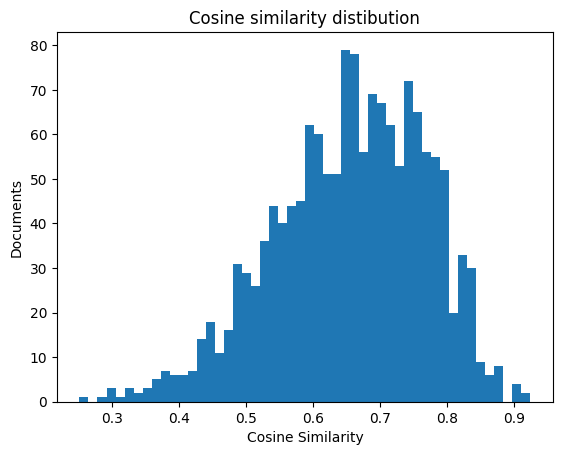

In [44]:
values = [x[0] for x in sim_list]

plt.hist(values, bins=50)
plt.title('Cosine similarity distibution')
plt.xlabel('Cosine Similarity')
plt.ylabel('Documents')

## 3) Experiment with Glove

In [10]:
import gensim.downloader as api
glove_model = api.load('glove-twitter-25')

[=================================================-] 98.0% 102.7/104.8MB downloaded


Counting the words that are known to GloVe and add to df

In [14]:
df['known_to_glove'] = df['txt'].apply(lambda x : sum([1 for item in x.split(' ') if glove_model.__contains__(item)]))

In [15]:
df.head()

,txt,sentiment,num_of_words,known_to_glove
0,stuning even for the non-gamer: this sound tra...,1,80,72
1,the best soundtrack ever to anything.: i'm rea...,1,97,82
2,amazing!: this soundtrack is my favorite music...,1,129,96
3,excellent soundtrack: i truly like this soundt...,1,118,86
4,"remember, pull your jaw off the floor after he...",1,87,62


Most words in our dataset are known to GloVe  (this is before pre-processing)


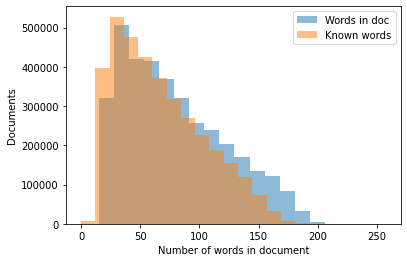

In [ ]:
plt.hist(df['num_of_words'], alpha=0.5, label='Words in doc', bins=20)
plt.hist(df['known_to_glove'], alpha=0.5, label='Known words', bins=20)

plt.xlabel('Number of words in document')
plt.ylabel('Documents')
plt.legend();

In [ ]:
glove_model.similar_by_word('israel')

[('iran', 0.8881680369377136),
 ('gaza', 0.8732103705406189),
 ('hamas', 0.8651652336120605),
 ('libya', 0.8641098141670227),
 ('nigeria', 0.8597480058670044),
 ('uganda', 0.8591971397399902),
 ('india', 0.8569527268409729),
 ('crimea', 0.8561787605285645),
 ('assad', 0.8561551570892334),
 ('ukraine', 0.8492863178253174)]

Sampling random word and their nearest neighbohrs

In [ ]:
import random

for _ in range(20):
    random_str = df.sample(1)['txt'].values[0].split()
    random_index = random.randint(0, len(random_str))    
    random_word = random_str[random.randint(0, len(random_str))]
    if glove_model.__contains__(random_word):
        most_similar_word = glove_model.similar_by_word(random_word)[0][0]
        print(f'Word: {random_word}\t Similar to: {most_similar_word}')
    else:
        print(f'The word: {random_word} does not exist in the GloVe dataset')

Word: was	 Similar to: had
Word: the	 Similar to: of
Word: abundance	 Similar to: abundant
Word: dollar	 Similar to: dollars
The word: plug. does not exist in the GloVe dataset
Word: universe	 Similar to: earth
Word: highlighter	 Similar to: lampshade
Word: sounded	 Similar to: freaked
Word: with	 Similar to: and
Word: it	 Similar to: that
Word: at	 Similar to: home
Word: i	 Similar to: 'm
Word: were	 Similar to: are
Word: this	 Similar to: now
Word: well	 Similar to: sure
Word: is	 Similar to: was
Word: quickly	 Similar to: faster
Word: be	 Similar to: not
The word: together. does not exist in the GloVe dataset
Word: what	 Similar to: how


## Working with Word2Vec

Upload

In [ ]:
from gensim import models
run_w2v = False  # The COLAB notebook crashes when uploading the W2V model

if run_w2v:
    w2v_model = models.KeyedVectors.load_word2vec_format(my_dir + 'GoogleNews-vectors-negative300.bin', binary=True)

    for _ in range(20):
        random_str = df.sample(1)['txt'].values[0].split()
        random_index = random.randint(0, len(random_str))    
        random_word = random_str[random.randint(0, len(random_str))]
        if glove_model.__contains__(random_word):
            most_similar_word = w2v_model.similar_by_word(random_word)[0][0]
            print(f'Word: {random_word}\t Similar to: {most_similar_word}')
        else:
            print(f'The word: {random_word} does not exist in the GloVe dataset')

## Analyzing stop words

Credit: https://www.kaggle.com/code/shahules/basic-eda-cleaning-and-glove/notebook

In [16]:
df_temp = df.sample(10000)  # choose a small portion of the dataset to work with

In [17]:
from collections import defaultdict

labal_0_corpus = []
labal_1_corpus = []

# sentiment 0
for x in df_temp[df_temp['sentiment']==0]['txt'].str.split():
        for i in x:
            labal_0_corpus.append(i)

# sentiment 1
for x in df_temp[df_temp['sentiment']==1]['txt'].str.split():
        for i in x:
            labal_1_corpus.append(i)

Analyzing sentiment 0



In [18]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [19]:
from nltk.corpus import stopwords

stop=set(stopwords.words('english'))

dic_0 = defaultdict(int)
for word in labal_0_corpus:
    if word in stop:
        dic_0[word]+=1
        
top_0 = sorted(dic_0.items(), key=lambda x:x[1],reverse=True)[:10] 

Analyzing sentiment 1

In [20]:
dic_1 = defaultdict(int)
for word in labal_1_corpus:
    if word in stop:
        dic_1[word]+=1
        
top_1 = sorted(dic_1.items(), key=lambda x:x[1],reverse=True)[:10] 

In [21]:
top_0


[('the', 20930),
 ('i', 10960),
 ('to', 9951),
 ('a', 9781),
 ('and', 9717),
 ('of', 7945),
 ('this', 7201),
 ('it', 6989),
 ('is', 6518),
 ('in', 4430)]

In [22]:
top_1

[('the', 17801),
 ('and', 11167),
 ('a', 10033),
 ('to', 9056),
 ('i', 8927),
 ('of', 7651),
 ('is', 7010),
 ('this', 6743),
 ('it', 6163),
 ('in', 4533)]

## Experiment with BoW

In [ ]:
def word_extraction(sentence):    
  ''' gets a sentence and returns a 
  list of words = BoW  '''
  ignore = []    # for now we will not igone any words
  words = re.sub("[^\w]", " ",  sentence).split()    
  cleaned_text = [w.lower() for w in words if w not in ignore] # i'm not sure we need to lower - all are lower already
  return cleaned_text

In [ ]:
# original
print(short_train_sentences[0])
print(len(short_train_sentences[0].split(' ')))
# proccesed
print(word_extraction(short_train_sentences[0]))
print(len(word_extraction(short_train_sentences[0])))

# for some reason "Don't" was splited to "don" and "t" :(:(:()))

In [ ]:
# original
print(short_train_sentences[110])
print(len(short_train_sentences[110].split(' ')))
# proccesed
print(word_extraction(short_train_sentences[110]))
print(len(word_extraction(short_train_sentences[110])))